In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import helper

#percentage of training data uses as validation
valid_size = 0.2
batch_size = 20
dir='/data/landmark_images'


train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(dir+'/train', transform = train_transforms)
test_data = datasets.ImageFolder(dir+'/test', transform = test_transforms)
print(len(train_data))

#obtaining training indices 
number_of_traindata=len(train_data)
indices = list(range(number_of_traindata))
np.random.shuffle(indices)
split = int(np.floor(valid_size*number_of_traindata))
train_idx, valid_idx = indices[split:],indices[:split]

#samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)
validloader = torch.utils.data.DataLoader(train_data, sampler = valid_sampler, batch_size = batch_size)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

loaders_scratch = {'train': trainloader, 'valid': validloader, 'test': testloader}


4996


### Visualize a Batch of Training Data


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
classes = train_data.classes
data_iter = iter(trainloader)
images,labels = next(data_iter)
images = images.numpy()

fig = plt.figure(figsize=(30, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
#helper.imshow(images[0], normalize=False)


### Initialize use_cuda variable

In [ ]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()


Specify Loss Function and Optimizer


In [ ]:
from torch import nn
import torch.optim as optim

criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    optimizer = optim.SGD(model.parameters(), lr=0.01)
     
    return optimizer
    

###Model Architecture

Creating a CNN to classify images of landmarks.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        
        #max pooling layer
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(64*28*28, 500)
        
        self.fc2 = nn.Linear(500, 50)
        
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        ## Define forward behavior
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.shape[0], -1)
        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Training Algorithm


In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initializing tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initializing variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            train_loss = train_loss + ((1/(batch_idx + 1)) * (loss.data.item() - train_loss))

            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1/(batch_idx + 1)) * (loss.data.item() - valid_loss))
            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

Experiment with the Weight Initialization



In [ ]:
def custom_weight_init(m):
    # implementing a weight initialization strategy
    classname = m.__class__.__name__
    
    if classname.find('Linear') != -1:
            n = m.in_features
            y = (1.0/np.sqrt(n))
            m.weight.data.normal_(0, y)
            m.bias.data.fill_(0)
    
    
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 7778.324944 	Validation Loss: 1916.299113
Validation loss decreased (inf --> 1916.2991).  Saving model ...
Epoch: 2 	Training Loss: 7746.269026 	Validation Loss: 1907.008193
Validation loss decreased (1916.2991 --> 1907.0082).  Saving model ...
Epoch: 3 	Training Loss: 7626.922938 	Validation Loss: 1854.757076
Validation loss decreased (1907.0082 --> 1854.7571).  Saving model ...
Epoch: 4 	Training Loss: 7506.343214 	Validation Loss: 1833.927268
Validation loss decreased (1854.7571 --> 1833.9273).  Saving model ...
Epoch: 5 	Training Loss: 7448.280871 	Validation Loss: 1826.011242
Validation loss decreased (1833.9273 --> 1826.0112).  Saving model ...
Epoch: 6 	Training Loss: 7354.543395 	Validation Loss: 1809.176709
Validation loss decreased (1826.0112 --> 1809.1767).  Saving model ...
Epoch: 7 	Training Loss: 7255.464892 	Validation Loss: 1778.652740
Validation loss decreased (1809.1767 --> 1778.6527).  Saving model ...
Epoch: 8 	Training Loss: 7221.245805 	Va

Train and Validate the Model


In [ ]:
num_epochs = 100

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 7776.117534 	Validation Loss: 1916.573402
Validation loss decreased (inf --> 1916.5734).  Saving model ...
Epoch: 2 	Training Loss: 7760.258771 	Validation Loss: 1912.888829
Validation loss decreased (1916.5734 --> 1912.8888).  Saving model ...
Epoch: 3 	Training Loss: 7710.794195 	Validation Loss: 1897.602315
Validation loss decreased (1912.8888 --> 1897.6023).  Saving model ...
Epoch: 4 	Training Loss: 7595.132598 	Validation Loss: 1847.621397
Validation loss decreased (1897.6023 --> 1847.6214).  Saving model ...
Epoch: 5 	Training Loss: 7474.654190 	Validation Loss: 1822.332296
Validation loss decreased (1847.6214 --> 1822.3323).  Saving model ...
Epoch: 6 	Training Loss: 7350.004662 	Validation Loss: 1802.098932
Validation loss decreased (1822.3323 --> 1802.0989).  Saving model ...
Epoch: 7 	Training Loss: 7250.656417 	Validation Loss: 1787.695124
Validation loss decreased (1802.0989 --> 1787.6951).  Saving model ...
Epoch: 8 	Training Loss: 7181.222992 	Va

Test the Model


In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.338340


Test Accuracy: 42% (534/1250)


A CNN to Classify Landmarks (using Transfer Learning)



In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

import helper

#percentage of training data uses as validation
valid_size = 0.2

batch_size = 20
dir='/data/landmark_images'

train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(dir+'/train', transform = train_transforms)
test_data = datasets.ImageFolder(dir+'/test', transform = test_transforms)
print(len(train_data.classes))
#obtaining training indices 
number_of_traindata=len(train_data)
indices = list(range(number_of_traindata))
np.random.shuffle(indices)
split = int(np.floor(valid_size*number_of_traindata))
train_idx, valid_idx = indices[split:],indices[:split]

#define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
classes = [class_.split(".")[1].replace("_", " ") for class_ in train_data.classes]

trainloader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)
validloader = torch.utils.data.DataLoader(train_data, sampler = valid_sampler, batch_size = batch_size)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

loaders_transfer = {'train': trainloader, 'valid': validloader, 'test': testloader}





50


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
#classes = train_data.classes
data_iter = iter(trainloader)
images,labels = next(data_iter)
images = images.numpy()

fig = plt.figure(figsize=(30, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
#helper.imshow(images[0], normalize=False)

Specify Loss Function and Optimizer



In [ ]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

In [ ]:
## TODO: select loss function
from torch import nn
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)
    return optimizer
    

Model Architecture

In [ ]:
model_transfer = models.vgg16(pretrained=True)

print(model_transfer)

for param in model_transfer.features.parameters():
    param.requires_grad = False
    
n_input = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_input,50)
model_transfer.classifier[6]=last_layer

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Train and Validate the Model

In [ ]:
num_epochs = 20
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)
            train_loss = train_loss + ((1/(batch_idx + 1)) * (loss.data.item() - train_loss))

            
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1/(batch_idx + 1)) * (loss.data.item() - valid_loss))
            
            

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model



In [ ]:
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

model_transfer.load_state_dict(torch.load('model_transfer.pt')) 

Epoch: 1 	Training Loss: 4973.0085 	Validation Loss: 1042.1975
Validation loss decreased (inf --> 1042.1975).  Saving model ...
Epoch: 2 	Training Loss: 3857.1415 	Validation Loss: 897.2536
Validation loss decreased (1042.1975 --> 897.2536).  Saving model ...
Epoch: 3 	Training Loss: 3486.5701 	Validation Loss: 831.2594
Validation loss decreased (897.2536 --> 831.2594).  Saving model ...
Epoch: 4 	Training Loss: 3277.2473 	Validation Loss: 811.1759
Validation loss decreased (831.2594 --> 811.1759).  Saving model ...
Epoch: 5 	Training Loss: 3053.6192 	Validation Loss: 771.5388
Validation loss decreased (811.1759 --> 771.5388).  Saving model ...
Epoch: 6 	Training Loss: 2928.5961 	Validation Loss: 751.0712
Validation loss decreased (771.5388 --> 751.0712).  Saving model ...
Epoch: 7 	Training Loss: 2763.9034 	Validation Loss: 757.3421
Epoch: 8 	Training Loss: 2614.2509 	Validation Loss: 723.3538
Validation loss decreased (751.0712 --> 723.3538).  Saving model ...
Epoch: 9 	Training Loss

### (IMPLEMENTATION) Test the Model

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))   
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.894163


Test Accuracy: 75% (939/1250)


 A Landmark Prediction Algorithm

In [ ]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    
    img = Image.open(img_path).convert('RGB')
    
    img_transforms = transforms.Compose([
                     transforms.Resize(256),
                     transforms.CenterCrop(224),
                     transforms.ToTensor(),
                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
        
                ])
    
    img = img_transforms(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()
        
    output = model_transfer(img)
    top_values, top_idx = output.topk(k)
        
    top_classes = [classes[class_id] for class_id in top_idx[0].tolist()]
    return top_classes

# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Brooklyn Bridge',
 'Sydney Harbour Bridge',
 'Sydney Opera House']

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ').split('.')[0]}")
    print(f"Predicted Label: \n {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")
    
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

Actual Label: Golden Gate Bridge
Predicted Label: 
 Golden Gate Bridge, Forth Bridge, or Brooklyn Bridge?


Testing the Algorithm


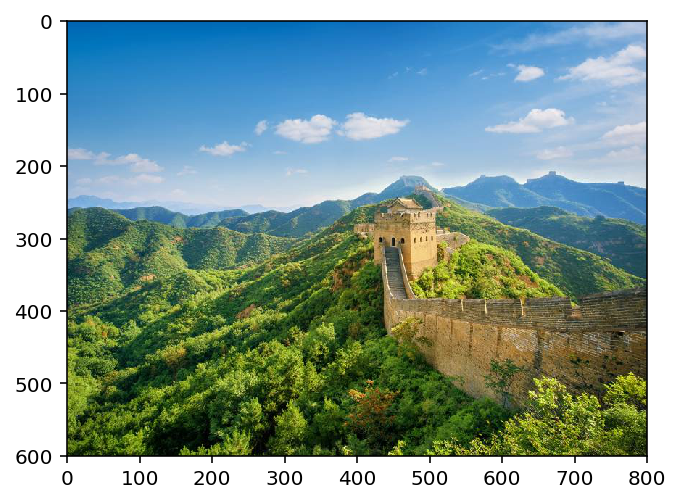

Predicted Label: 
 Machu Picchu, Edinburgh Castle, or Great Wall of China?


In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    #print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ').split('.')[0]}")
    print(f"Predicted Label: \n {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")
    
    

# test on a sample image
suggest_locations('images/gwc3.jpg')

In [ ]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    #print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ').split('.')[0]}")
    print(f"Predicted Label: \n {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")
    
    

# test on a sample image
suggest_locations('images/gd2.jpg')

Predicted Label: 
 Golden Gate Bridge, Brooklyn Bridge, or Stockholm City Hall?


In [ ]:
def suggest_locations(img_path):
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    #print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ').split('.')[0]}")
    print(f"Predicted Label: \n {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")
    
    

# test on a sample image
suggest_locations('images/gwc2.jpg')

Predicted Label: 
 Banff National Park, Niagara Falls, or Edinburgh Castle?


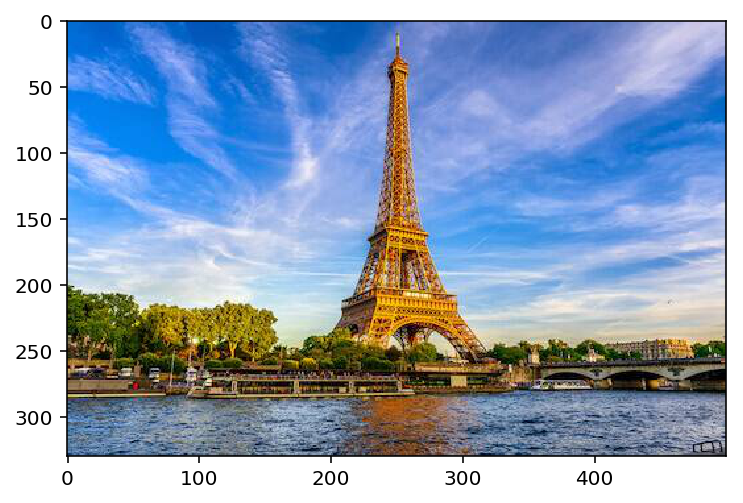

Predicted Label: 
 Vienna City Hall, Eiffel Tower, or Terminal Tower?


In [ ]:
def suggest_locations(img_path):
    
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    img = Image.open(img_path).convert('RGB')
    plt.imshow(img)
    plt.show()

    #print(f"Actual Label: {img_path.split('/')[2][3:].replace('_',' ').split('.')[0]}")
    print(f"Predicted Label: \n {predicted_landmarks[0]}, {predicted_landmarks[1]}, or {predicted_landmarks[2]}?")
    
    

# test on a sample image
suggest_locations('images/par.jpg')